# Global random audiogram and p50 values

In [1]:
import os.path as op
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy

from scripts.utils import *
from funcs.global_random_audiogram import DataFormatter, DataProcessor
# from funcs.threshold_analysis import interp
from funcs.plots import VisualChecksP50

### Set paths and parameters

In [2]:
data_path = get_path("dataframes")
fig_dir = get_path("figures")

audiograms_input_file = "thresholds-3AFC_freqs.pkl"
random_audiograms_output_file = "global_random_audiograms.pkl"

overwrite_existing = False

xfreqs = list(np.geomspace(125, 8000, 100))
AFC_freqs = [125, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 6000, 8000]

### Load and reformat data

In [3]:
# Load data
thresholds_data = pd.read_pickle(op.join(data_path, audiograms_input_file))

# Compact data: create df with one row per audiogram (10 rows/participant)
short_data = DataFormatter.shorten_data(thresholds_data, AFC_freqs)

# Explode data: create df with one row per trial
trials_data = deepcopy(DataFormatter.lengthen_data(short_data))

### Global random audiograms

Filter trials from all the randomized conditions (Randomized task, Continuous/R and Cluster/R.

Make API requests for global random audiograms. Resample the obtained audiogram to 100 datapoints and save the dataframe to a pickle file if `overwrite_existing`.

Otherwise, load the existing global random audiograms from the pickle file.

In [4]:
output_abspath = op.join(data_path, random_audiograms_output_file)

if overwrite_existing or not op.isfile(output_abspath):
    print(f"Making API requests for the mommy audiograms. This can take a couple of minutes...")

    # Filter data from all random conditions
    random_trials_data = trials_data.loc[trials_data.pred.isin(['Bayesian', 'none'])]

    # Make the API compute the audiograms from the selected data and resample
    random_audiograms = DataProcessor.request_global_audiograms(random_trials_data, xfreqs)

    # Save global random audiograms to PKL file
    random_audiograms.to_pickle(output_abspath)
    del random_trials_data

else:
    print(f"Loading previously saved global random audiograms from '{random_audiograms_output_file}'...")
    random_audiograms = pd.read_pickle(output_abspath)

random_audiograms.head()

Loading previously saved global random audiograms from 'global_random_audiograms.pkl'...


,participant,random_tested_frequencies,random_tested_levels,random_responses,random_thresholds,frequencies,random_ntones
0,cbtxie,"[1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1500....","[60.0, 40.0, 20.0, 0.0, 10.0, -10.0, 10.0, -10...","[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[11.789318844963411, 10.918903180865687, 10.02...","[125.0, 130.36297268079934, 135.95603716939888...","[[Bayesian, 68], [Cluster, 64], [Continuous, 57]]"
0,cmzntn,"[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1500....","[60.0, 40.0, 20.0, 0.0, -20.0, -10.0, 10.0, -1...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[-5.133246605775844, -4.632338191228925, -4.11...","[125.0, 130.36297268079934, 135.95603716939888...","[[Bayesian, 51], [Cluster, 34], [Continuous, 70]]"
0,cwzopc,"[1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1500....","[60.0, 40.0, 20.0, 0.0, 10.0, 30.0, 10.0, -10....","[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.599113812546036, 0.25529021684206454, -0.00...","[125.0, 130.36297268079934, 135.95603716939888...","[[Bayesian, 53], [Cluster, 64], [Continuous, 47]]"
0,ddmfvc,"[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1500....","[60.0, 40.0, 20.0, 0.0, -20.0, -10.0, 10.0, -1...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[8.038503153117093, 6.906837100444384, 5.83713...","[125.0, 130.36297268079934, 135.95603716939888...","[[Bayesian, 56], [Cluster, 38], [Continuous, 56]]"
0,eqdcwr,"[1000.0, 1000.0, 1000.0, 1000.0, 1500.0, 1500....","[56.7, 36.7, 16.7, -3.3, 6.7, 26.7, 6.7, -13.3...","[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[-1.4200795108077284, -1.7904066092090023, -2....","[125.0, 130.36297268079934, 135.95603716939888...","[[Bayesian, 51], [Cluster, 50], [Continuous, 53]]"


### Distances with random threshold

For each tone presented during the experiment, compute the distance

In [5]:
# remove trials of initialization phase from Cluster and Continuous
trials_data = trials_data[~((trials_data.paradigm.isin(['Continuous', 'Cluster'])) & (trials_data.is_init == True))]

# Insert new columns: for each tone tested, get random threshold and compute distance
trials_data.insert(9, 'random_threshold', np.zeros(len(trials_data)))
trials_data.insert(10, 'random_distance', np.zeros(len(trials_data)))

trials_data.reset_index(inplace=True)

In [6]:
def compute_random_threshold(row):
    participant_data = random_audiograms_dict[row.participant]
    random_audiogram = participant_data['random_thresholds']
    audiogram_frequencies = participant_data['frequencies']
    freq = row.tested_frequencies
    return random_audiogram[audiogram_frequencies.index(freq)] if freq in audiogram_frequencies else interp(freq, audiogram_frequencies, random_audiogram)

# Create dictionary for quick access to participant data
random_audiograms_dict = random_audiograms.set_index('participant')[['random_thresholds', 'frequencies']].to_dict('index')

# Compute the random threshold for the frequency of each trial
trials_data['random_threshold'] = trials_data.apply(compute_random_threshold, axis=1)

# Compute the distance
trials_data['random_distance'] = trials_data.tested_levels - trials_data.random_threshold

# merge new data to short_data
short_data = DataFormatter.add_distances_to_short_data(short_data, trials_data)

del random_audiograms_dict

### Logistic regression and p50

Compute **"psychometric" curves** by fitting a sigmoid to the participant's response as a function of the presented tone's distance from the global random threshold.
Interpolate **p50 values** (i.e. the threshold distance in dB corresponding to a probability of detection = 50%).

Loop through each paradigm in trials_data:
- For each paradigm, loop through each prediction condition:
  - For each prediction condition, loop through the participants:
     - **Fit a logistic regression model to each participant's responses**.
     - **Compute individual p50 values**.
     - Check for any anomalies. Plot anomaly and set p50 to NaN if:
          - the sigmoid is inverted (decreasing probability of detection with increasing dB level),
          - the computed p50 value is outside of the range of tested tones.
 - Compute the average of the sigmoids and SEM across (non-problematic) participants for each condition.

---------------
3AFC

---------------
BAYESIAN

---------------
CLUSTER

 - hnxrev, Cluster (both)
Anomaly detected: p50 (-12.239) outside of tested dB range ([-5.742, 5.771])
p50 set to NaN and hnxrev already in list of problematic participants.

 - qmbami, Cluster (both)
Anomaly detected: p50 (-16.746) outside of tested dB range ([-10.11, 4.243])
p50 set to NaN and qmbami already in list of problematic participants.

 - wxbjqe, Cluster (both)
Anomaly detected: p50 (-8.536) outside of tested dB range ([-6.233, 5.995])
p50 set to NaN and wxbjqe already in list of problematic participants.

 - qmbami, Cluster (frequency)
Anomaly detected: Inverted sigmoid (max - min) = -0.185
p50 set to NaN and qmbami already in list of problematic participants.

 - wxbjqe, Cluster (time)
Anomaly detected: p50 (-4.861) outside of tested dB range ([-3.325, 6.962])
p50 set to NaN and wxbjqe already in list of problematic participants.

---------------
CONTINUOUS

 - cmzntn, Continuous (both)
Anomaly detec

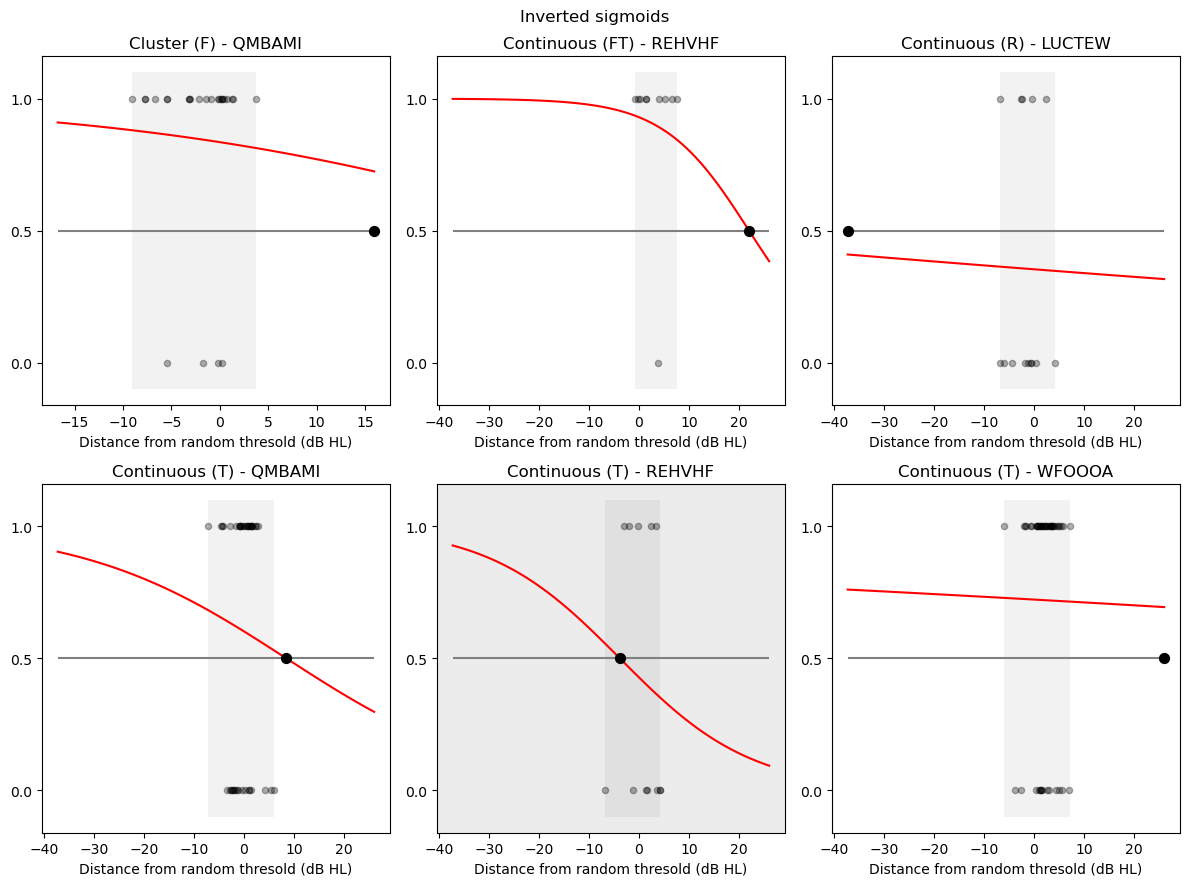

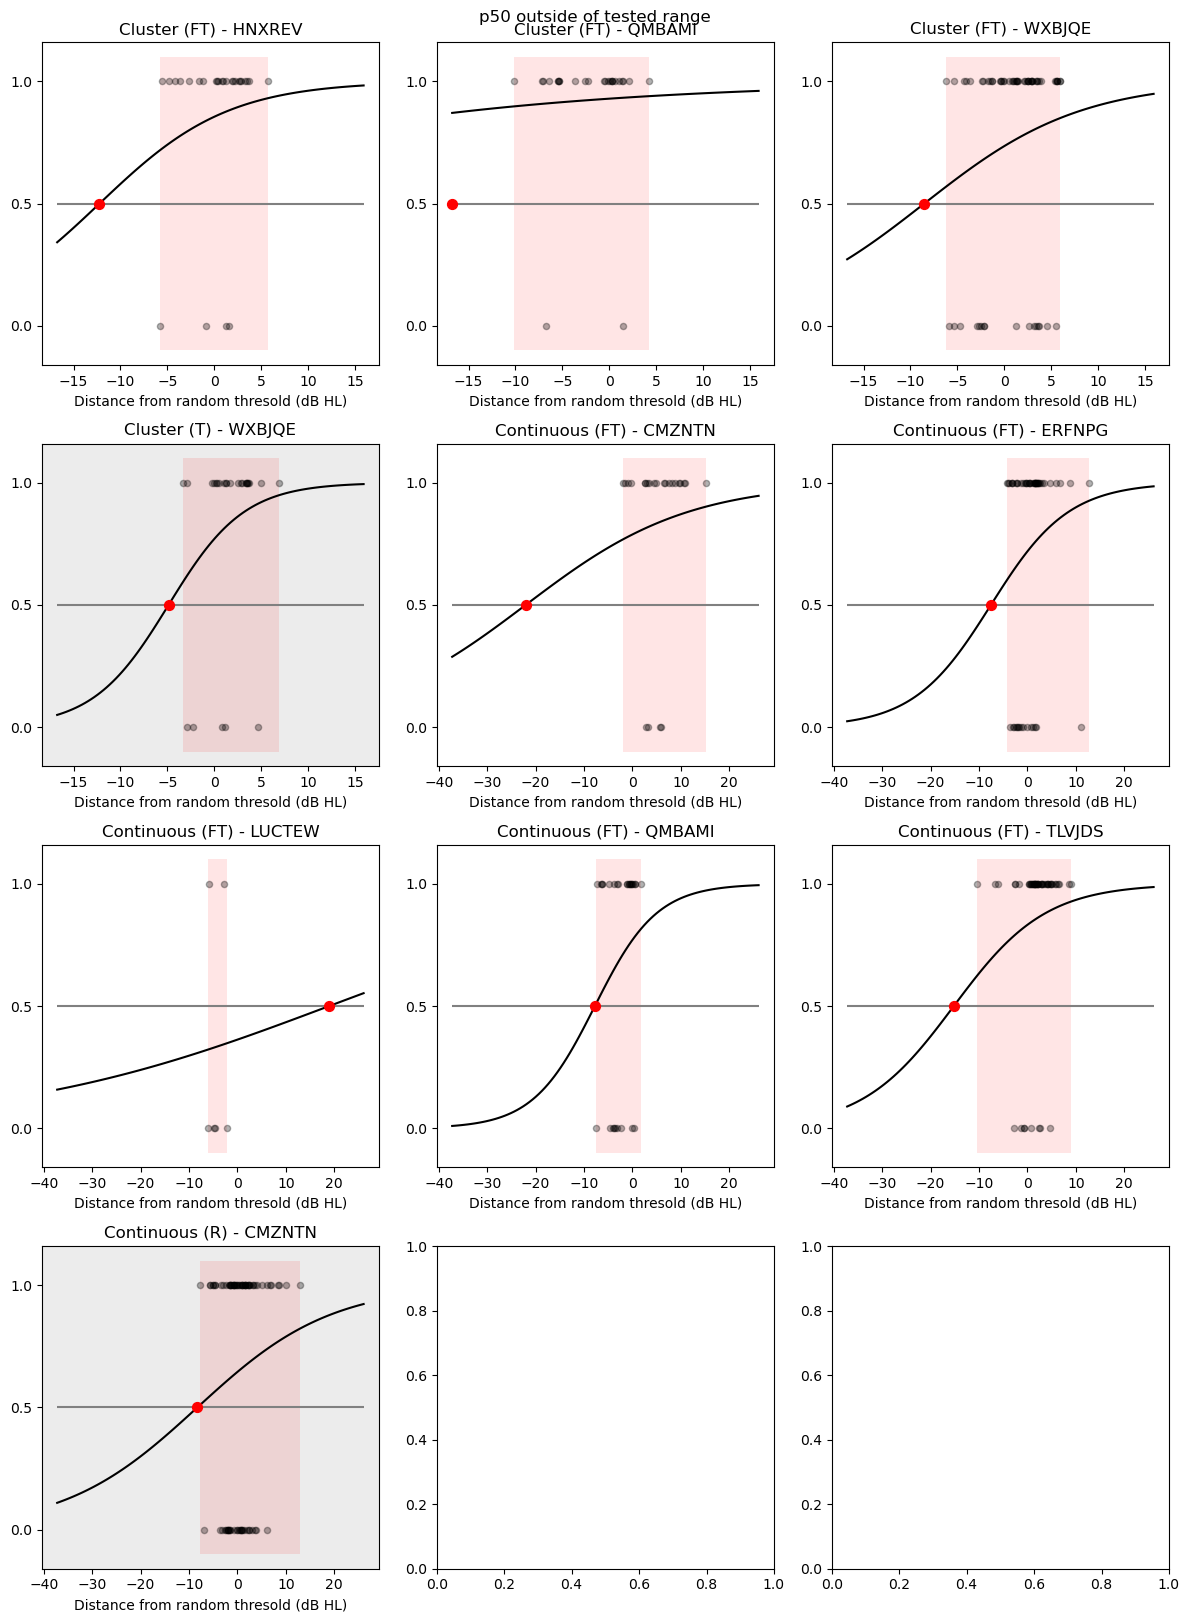

In [7]:
fig_inverted, axs_inverted = plt.subplots(nrows=2, ncols=3, figsize=[12, 9])
axs_inverted = axs_inverted.flatten()
plt.suptitle("Inverted sigmoids")

fig_p50, axs_p50 = plt.subplots(nrows=4, ncols=3, figsize=[12, 16.5])
axs_p50 = axs_p50.flatten()
plt.suptitle("p50 outside of tested range")

subplot_counters = {'Inverted sigmoid': 0, 'p50 outside range': 0}
problematic_participants = {}

pseudo_psychometric_curves = pd.DataFrame()

for paradigm, paradigm_group in trials_data.groupby('paradigm'):
    print(f"---------------\n{paradigm.upper()}\n")

    problematic_participants[paradigm] = {"Inverted sigmoid": [],
                                          "p50 outside range": []}

    curve, problematic_participants[paradigm], subplot_counters = DataProcessor.get_sigmoid_and_p50(DataProcessor,
        paradigm_group, paradigm, problematic_participants[paradigm], subplot_counters, axs_inverted, axs_p50)

    pseudo_psychometric_curves = pd.concat([pseudo_psychometric_curves, curve])

fig_inverted.tight_layout()
fig_p50.tight_layout()

del subplot_counters, fig_inverted, fig_p50, axs_inverted, axs_p50, curve

### Summarize issues

In [8]:
for paradigm, anomaly_counts in problematic_participants.items():
    print(f"- {paradigm}:")

    if all(len(participants) == 0 for participants in anomaly_counts.values()):
        print("No issues\n")
    else:
        for anomaly_type, participants in anomaly_counts.items():
            if participants: # check if the list is not empty
                print(f"{anomaly_type} for {len(participants)} participants: {participants}")

        # Compute and print total number of unique problematic participants for each paradigm
        total_participants = set()
        for participants in anomaly_counts.values():
            total_participants.update(participants)
        print(f"Total unique problematic participants in {paradigm}: {len(total_participants)}\n")

del anomaly_type, anomaly_counts, participants, total_participants

- 3AFC:
No issues

- Bayesian:
No issues

- Cluster:
Inverted sigmoid for 1 participants: ['qmbami']
p50 outside range for 3 participants: ['hnxrev', 'qmbami', 'wxbjqe']
Total unique problematic participants in Cluster: 3

- Continuous:
Inverted sigmoid for 4 participants: ['rehvhf', 'luctew', 'qmbami', 'wfoooa']
p50 outside range for 5 participants: ['cmzntn', 'erfnpg', 'luctew', 'qmbami', 'tlvjds']
Total unique problematic participants in Continuous: 7



### Get average and SEM of sigmoids across participants

Compute the average sigmoid and SEM across (non-problematic) participants for each condition.

In [9]:
average_and_sem = pseudo_psychometric_curves.loc[~pseudo_psychometric_curves.problematic].groupby(['paradigm', 'pred', 'random_distance'])['sigmoid_probas'].agg(['mean', 'sem']).reset_index()

pseudo_psychometric_curves = pd.merge(pseudo_psychometric_curves, average_and_sem, how='left', on=['paradigm', 'pred', 'random_distance'])
pseudo_psychometric_curves.rename(columns={"mean": "sigmoid_mean", "sem": "sigmoid_sem"}, inplace=True)

### Save dataframes

In [10]:
pseudo_psychometric_curves.to_pickle(op.join(data_path, "sigmoid_data.pkl"))

trials_data.to_pickle(op.join(data_path, "individual_trials_data.pkl"))

### Plot all non-problematic results

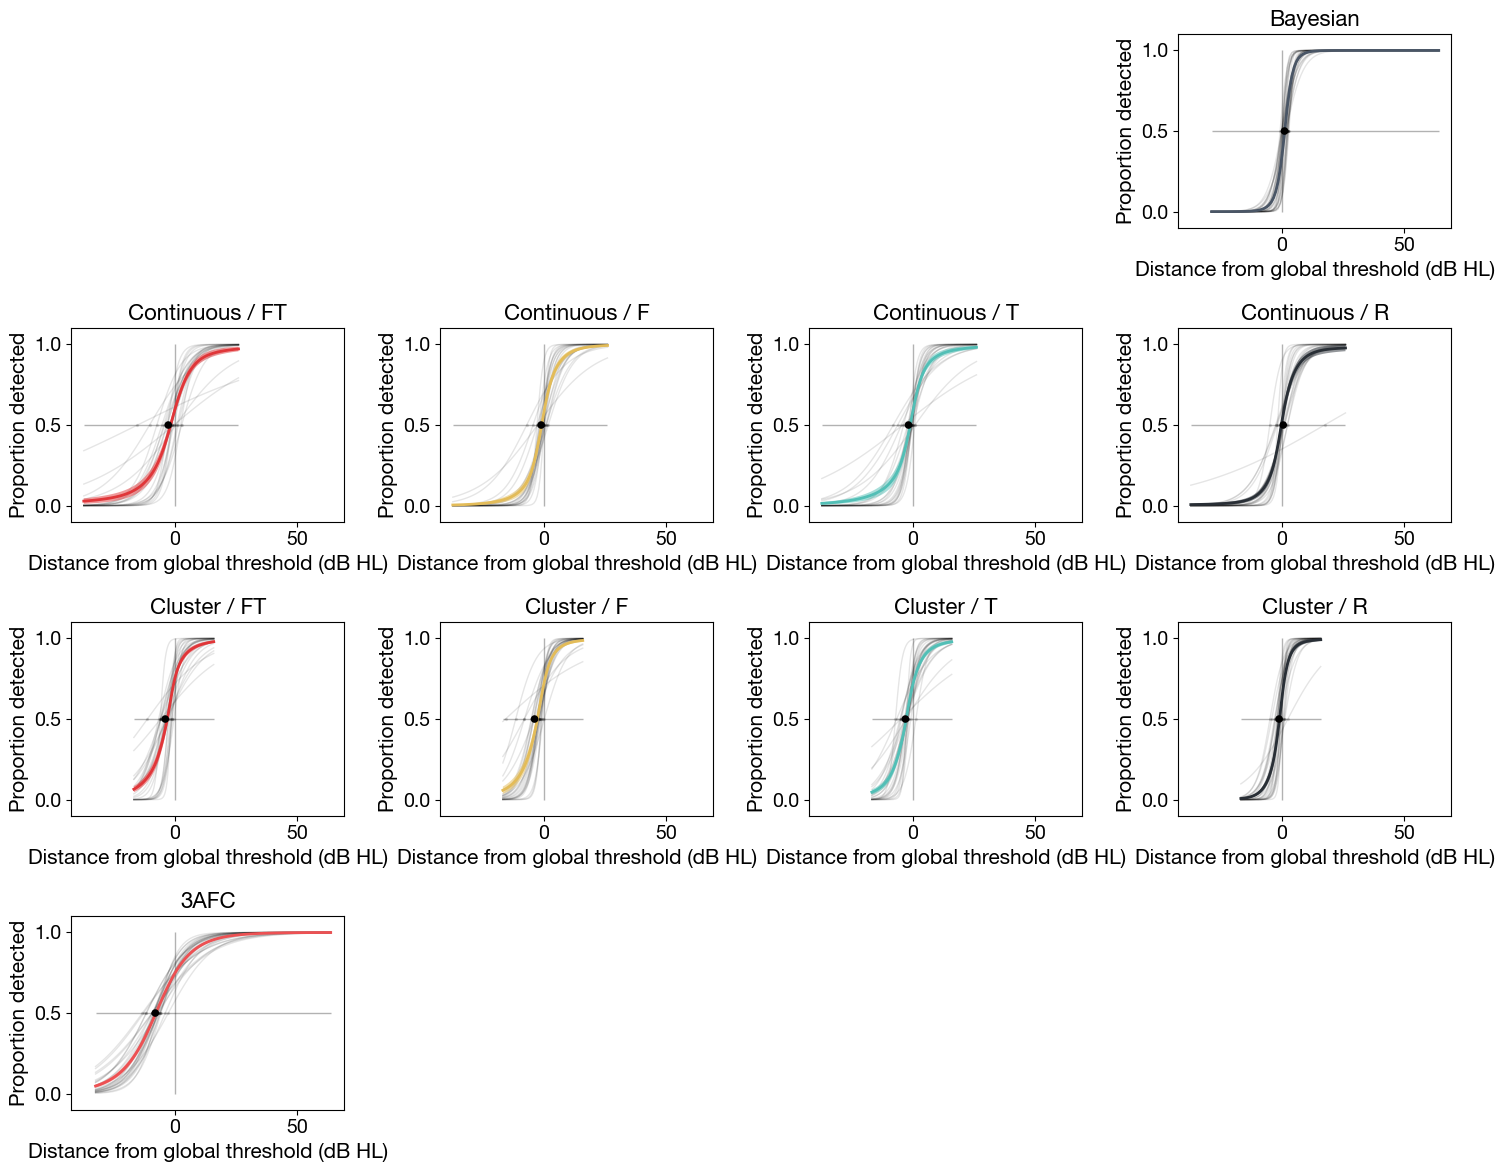

In [11]:
VisualChecksP50.plot_all_sigmoids(pseudo_psychometric_curves)